## Poročilo vaja 3.2
#### Preverjanje hipotez: Učinki HIIT vadbe pri poklicnih nogometaših

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, mannwhitneyu, shapiro
import os

path = os.getcwd()

# convert ',' to '.' in the data
cols_to_convert = ['LACTATE THRESHOLD 1 POST TEST SPEED (km/h)',
                   'LACTATE THRESHOLD 2 PRE TEST SPEED (km/h)',
                   'LACTATE THRESHOLD 2 POST TEST SPEED (km/h)',
                   'vVO2max/ km/h    (pre)',
                   'vVo2max/ km/h (post)']

converters = {col: lambda x: float(x.replace(',', '.')) for col in cols_to_convert}

df = pd.read_csv(path + '\\data\\UJ_HIIT_groups-pre-post-intervention-za-analizo.csv', delimiter=';', converters=converters)

# convert int64 columns into float64
int_cols = df.select_dtypes(include='int').columns
df[int_cols] = df[int_cols].astype('float64')

In [41]:
display(df.head())

,NAME,LACTATE THRESHOLD 1 PRE-TEST HEART RATE (bpm),LACTATE THRESHOLD 1 POST TEST HEART RATE (bpm),LACTATE THRESHOLD 1 PRE TEST SPEED (km/h),LACTATE THRESHOLD 1 POST TEST SPEED (km/h),LACTATE THRESHOLD 1 PRE TEST TIME (sec),LACTATE THRESHOLD 1 POST TEST TIME (sec),LACTATE THRESHOLD 2 PRE TEST HEART RATE (bpm),LACTATE THRESHOLD 2 POST TEST HEART RATE (bpm),LACTATE THRESHOLD 2 PRE TEST SPEED (km/h),LACTATE THRESHOLD 2 POST TEST SPEED (km/h),LACTATE THRESHOLD 2 PRE TEST TIME (sec),LACTATE THRESHOLD 2 POST TEST TIME (sec),V02MAX (ml/kg/min) PRE-TEST,V02MAX (ml/kg/min) POST TEST,HRmax (pre),Hrmax (post),vVO2max/ km/h (pre),vVo2max/ km/h (post),Time @V02max occurance (pre),Time @V02max occurance (post),Group
0,HIIT_1,79.0,96.0,6.0,6.0,172.0,110.0,137.0,163.0,9.6,10.8,342.0,464.0,39.0,48.0,166.0,182.0,13.2,15.6,610.0,784.0,1.0
1,HIIT_17,114.0,126.0,6.0,6.0,212.0,168.0,156.0,172.0,9.6,12.0,382.0,540.0,42.0,48.0,172.0,175.0,14.4,18.0,637.0,853.0,1.0
2,HIIT_6,73.0,130.0,6.0,8.4,115.0,295.0,114.0,166.0,8.4,13.2,257.0,562.0,44.0,50.0,161.0,172.0,13.2,15.6,595.0,711.0,1.0
3,HIIT_12,92.0,125.0,6.0,8.4,89.0,299.0,132.0,152.0,9.6,12.0,352.0,540.0,42.0,48.0,175.0,180.0,13.2,15.6,574.0,750.0,1.0
4,HIIT_18,110.0,130.0,6.0,8.4,214.0,277.0,160.0,174.0,12.0,14.4,540.0,630.0,54.0,54.0,175.0,184.0,16.8,18.0,801.0,894.0,1.0


In [67]:
# descriptive statistics without checking for normality
pd.options.display.float_format = '{:.2f}'.format

cols = df.columns.tolist()[1:-1:]
table_pre = df[cols[:-1:2]]
table_post = df[cols[1::2]]
normality = [] 
norm_table = []
for pre, post in zip(table_pre, table_post):
    var_pre, var_post = df[pre], df[post]
    stat_pre, p_pre = shapiro(var_pre)
    stat_post, p_post = shapiro(var_post)
    p_pre_str = '<0.01' if p_pre < 0.01 else f'{p_pre:.3f}'
    p_post_str = '<0.01' if p_post < 0.01 else f'{p_post:.3f}'
    norm_table.append([pre, f'{stat_pre:.3f}', p_pre_str])
    norm_table.append([post, f'{stat_post:.3f}', p_post_str])
    
    if p_pre < 0.05 or p_post < 0.05:
        normality.append(False)
    else:
        normality.append(True)
        
norm_summary = pd.DataFrame(norm_table, columns=['', 'Statistic', 'p-value'])
    
display(norm_summary.style.set_caption('Table 1: Shapiro-Wilk test of normality')\
          .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '100%')]},
              {'selector': 'td', 'props': 'text-align: left;'}
          ])\
          .hide())

C:\Users\Jaka.Kovse\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,Statistic,p-value
LACTATE THRESHOLD 1 PRE-TEST HEART RATE (bpm),0.985,0.985
LACTATE THRESHOLD 1 POST TEST HEART RATE (bpm),0.873,0.020
LACTATE THRESHOLD 1 PRE TEST SPEED (km/h),1.000,1.000
LACTATE THRESHOLD 1 POST TEST SPEED (km/h),0.624,<0.01
LACTATE THRESHOLD 1 PRE TEST TIME (sec),0.871,0.018
LACTATE THRESHOLD 1 POST TEST TIME (sec),0.908,0.079
LACTATE THRESHOLD 2 PRE TEST HEART RATE (bpm),0.956,0.529
LACTATE THRESHOLD 2 POST TEST HEART RATE (bpm),0.809,<0.01
LACTATE THRESHOLD 2 PRE TEST SPEED (km/h),0.836,<0.01
LACTATE THRESHOLD 2 POST TEST SPEED (km/h),0.955,0.507


**Interpretacija testa normalnosti:** Spremenljivke ***LACATATE THRESHOLD 2 TEST TIME***, ***VO2MAX***, ***HRmax***, ***vVO2max/km/h*** in ***Time@VO2max occurance*** so normalno porazdeljene, saj p vrednosti Shapiro-Wilk testa pred in po intervenciji niso nižje od mejne vrednosti 0.05. To pomeni, da bomo vpliv intervencije preverjali s parnim t-testom, medtem, ko bomo za ostale spremenljivke uporabili Wilcoxon-ov test.

In [58]:

display(table_pre.describe().loc[[ '50%', '25%', '75%']].rename(index={
    '50%': 'median',
    '25%': '25th perc',
    '75%': '75th prec'
}).T.style.set_caption('Descriptive statistics: pre intervention')\
    .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '100%')]},
              {'selector': 'td', 'props': 'text-align: left;'}
          ]))

,median,25th perc,75th prec
LACTATE THRESHOLD 1 PRE-TEST HEART RATE (bpm),97.000000,91.250000,107.750000
LACTATE THRESHOLD 1 PRE TEST SPEED (km/h),6.000000,6.000000,6.000000
LACTATE THRESHOLD 1 PRE TEST TIME (sec),86.500000,67.500000,158.000000
LACTATE THRESHOLD 2 PRE TEST HEART RATE (bpm),137.500000,130.500000,154.750000
LACTATE THRESHOLD 2 PRE TEST SPEED (km/h),9.600000,8.400000,9.600000
LACTATE THRESHOLD 2 PRE TEST TIME (sec),335.500000,284.500000,379.500000
V02MAX (ml/kg/min) PRE-TEST,44.000000,42.000000,45.750000
HRmax (pre),169.500000,164.500000,175.000000
vVO2max/ km/h (pre),13.800000,13.200000,14.400000
Time @V02max occurance (pre),625.000000,536.500000,653.000000


In [53]:
table_post.describe().loc[['50%', '25%', '75%']].rename(index={
    '50%': 'median',
    '25%': '25th perc',
    '75%': '75th prec'
}).T.style.set_caption('Descriptive statistics: post intervention')\
    .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '100%')]},
              {'selector': 'td', 'props': 'text-align: left;'}
          ])

,median,25th perc,75th prec
LACTATE THRESHOLD 1 POST TEST HEART RATE (bpm),125.000000,121.000000,127.750000
LACTATE THRESHOLD 1 POST TEST SPEED (km/h),8.400000,6.000000,8.400000
LACTATE THRESHOLD 1 POST TEST TIME (sec),241.000000,195.000000,279.250000
LACTATE THRESHOLD 2 POST TEST HEART RATE (bpm),165.000000,155.250000,172.000000
LACTATE THRESHOLD 2 POST TEST SPEED (km/h),12.000000,9.900000,13.200000
LACTATE THRESHOLD 2 POST TEST TIME (sec),526.000000,405.250000,565.000000
V02MAX (ml/kg/min) POST TEST,49.500000,48.000000,53.000000
Hrmax (post),180.000000,176.500000,183.500000
vVo2max/ km/h (post),15.600000,15.600000,17.700000
Time @V02max occurance (post),778.000000,722.500000,847.000000


In [59]:
# draw some plots
def draw_bar_chart(val_vars: list, val_name: str, title_str: str):
    df_long = pd.melt(df,
                      id_vars=['NAME', 'Group'],
                      value_vars=val_vars,
                      var_name='Time',
                      value_name=val_name)
    
    df_long['Time'] = np.where(df_long['Time'] == val_vars[0], 'post', 'pre')
    plt.figure()
    sns.barplot(data=df_long, x='Group', y=val_name, hue='Time',)
    plt.title(title_str)

In [61]:
cols = list(df.columns)[1:-1:]
variable_pairs = [[cols[i], cols[i+1]] for i in range(0, len(cols), 2)]
val_names = ['Lactate Threshold HR 1',
             'Lactate Threshold speed 1',
             'Lactate Threshold time 1',
             'Lactate Threshold HR 2',
             'Lactate Threshold speed 2',
             'Lactate Threshold time 2',
             'VO2max', 'HRmax', 'vVO2max',
             'Time @V02max occurance']

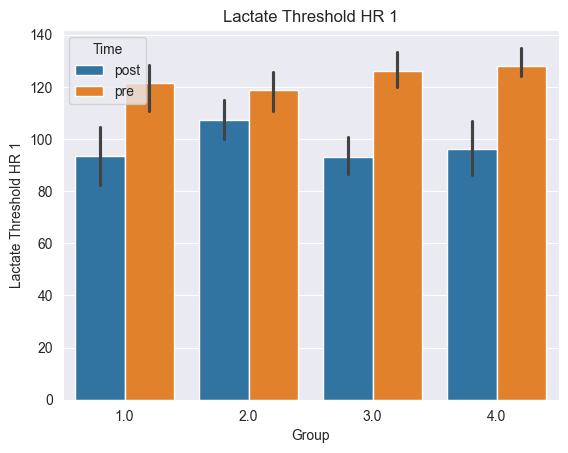

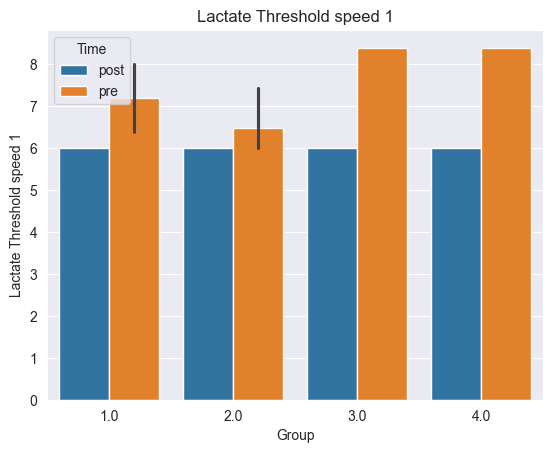

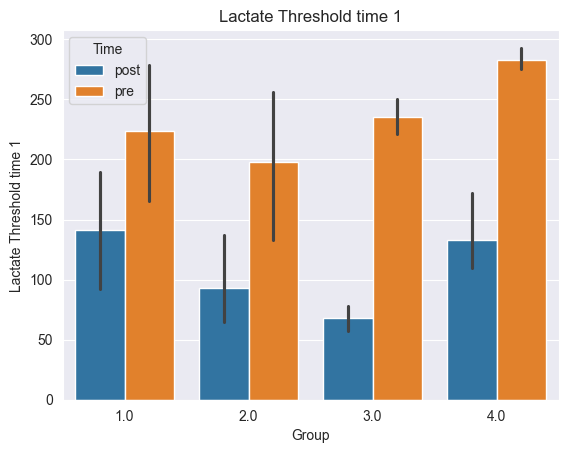

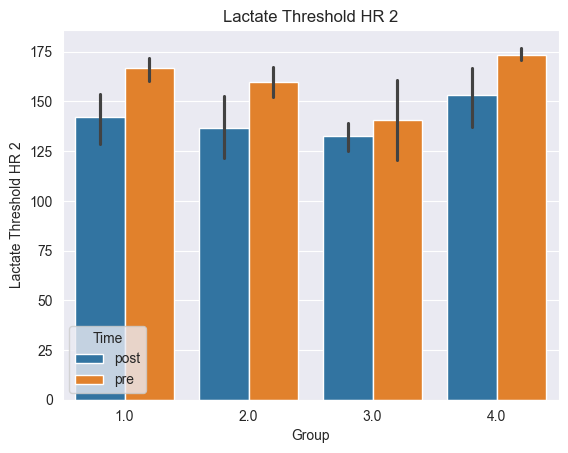

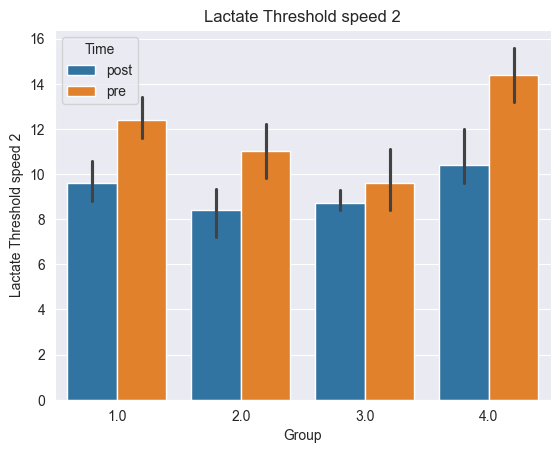

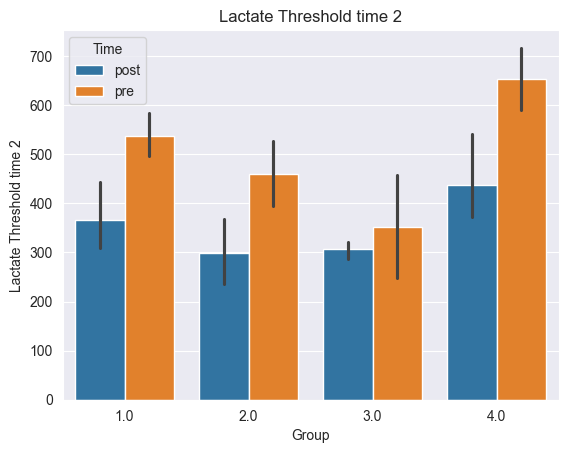

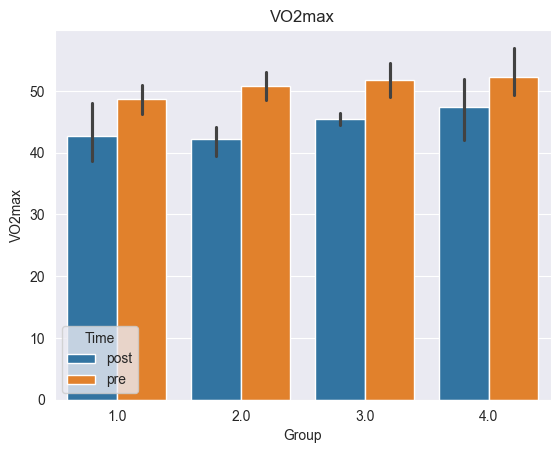

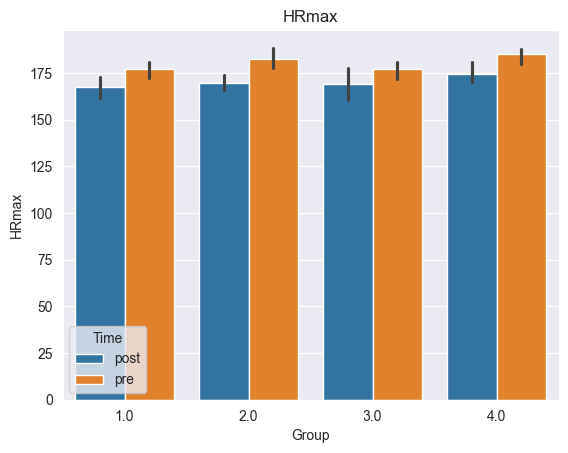

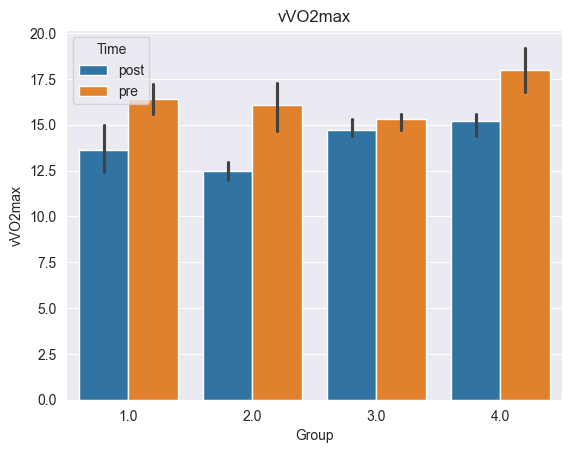

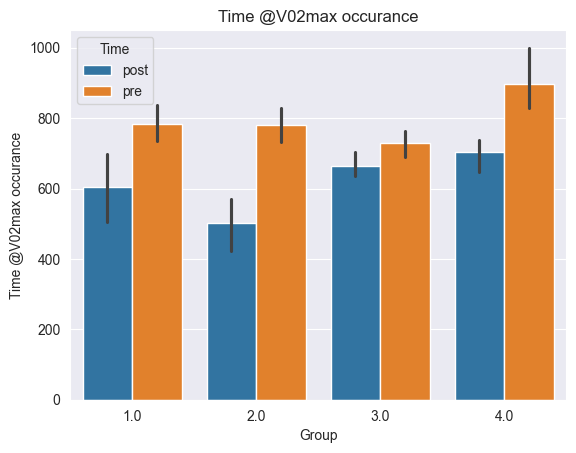

In [86]:
# draw bar charts for each variable pre- and post- intervention
for i in range(len(val_names)):
    draw_bar_chart(variable_pairs[i], val_names[i], title_str=val_names[i])

In [66]:
# create wilcoxon tests for all non-normally distributed variables and paired t-test for normally distributed variables
from scipy.stats import ttest_rel, wilcoxon
test_results = []

for pair, is_normal in zip(variable_pairs, normality):
    pre_data = df[pair[0]]
    post_data = df[pair[1]]
    if is_normal:
        stat, p = ttest_rel(pre_data, post_data)
        test_name = 'Paired t-test'
    else:
        stat, p = wilcoxon(pre_data, post_data, zero_method='wilcox', correction=False)
        test_name = 'Wilcoxon t-test'
    test_results.append({
        '': pair,
        'Test': test_name,
        'Statistic': stat,
        'p-value': p
    })

results_df = pd.DataFrame(test_results)
display(results_df.style.set_caption('Descriptive statistics: post intervention')\
    .set_table_styles([
              {'selector': 'caption', 'props': [('font-size', '16px'), 
                                                ('font-weight', 'bold'), 
                                                ('border-bottom', '1px solid black'),
                                                ('width', '100%')]},
              {'selector': 'td:first-child', 'props': [('text-align', 'left'),
                                           ('font-weight', 'bold')]}
          ])\
           .hide())
    

,Test,Statistic,p-value
"['LACTATE THRESHOLD 1 PRE-TEST HEART RATE (bpm)', 'LACTATE THRESHOLD 1 POST TEST HEART RATE (bpm)']",Wilcoxon t-test,5.500000,0.000107
"['LACTATE THRESHOLD 1 PRE TEST SPEED (km/h)', 'LACTATE THRESHOLD 1 POST TEST SPEED (km/h)']",Wilcoxon t-test,0.000000,0.000911
"['LACTATE THRESHOLD 1 PRE TEST TIME (sec)', 'LACTATE THRESHOLD 1 POST TEST TIME (sec)']",Wilcoxon t-test,7.000000,0.000145
"['LACTATE THRESHOLD 2 PRE TEST HEART RATE (bpm)', 'LACTATE THRESHOLD 2 POST TEST HEART RATE (bpm)']",Wilcoxon t-test,7.000000,0.000145
"['LACTATE THRESHOLD 2 PRE TEST SPEED (km/h)', 'LACTATE THRESHOLD 2 POST TEST SPEED (km/h)']",Wilcoxon t-test,0.000000,0.000591
"['LACTATE THRESHOLD 2 PRE TEST TIME (sec)', 'LACTATE THRESHOLD 2 POST TEST TIME (sec)']",Paired t-test,-5.538460,0.000036
"['V02MAX (ml/kg/min) PRE-TEST', 'V02MAX (ml/kg/min) POST TEST']",Paired t-test,-7.937485,0.000000
"['HRmax (pre)', 'Hrmax (post)']",Paired t-test,-7.098577,0.000002
"['vVO2max/ km/h (pre)', 'vVo2max/ km/h (post)']",Paired t-test,-6.767459,0.000003
"['Time @V02max occurance (pre)', 'Time @V02max occurance (post)']",Paired t-test,-7.093058,0.000002


**Interpretacija:** S parnim T-testom (normalna porazdelitev spremenljivk) in Wilcoxonov-im testom smo preverjali naslednji hipotezi.
H0: Ne obstajajo statistično značilne razlike za posamezno spremenljivko pred in po intervenciji (HIIT vadba).
H1: Obstajajo statistično značilne razlike za posamezno spremenljivko pred in po intervenciji.

P-vrednosti vseh testov so krepko pod mejno vrednostjo 0.05, zato lahko rečemo, da intervencija statistično značilno vpliva na maksimalni srčni utrip, maksimalno porabo kisika in nivo laktatnega praga. Ti fiziološki parametri so pokazatelji izboljšane kardiovaskularne sposobnosti in vzdržljivosti.